In [95]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
#import dataset
data = pd.read_csv('employee_retention_data.csv')
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [3]:
#There is not null data
data.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [45]:
#Evaluate if a employee is still working for the company and evaluate each employee's survival days
data.loc[data['quit_date'].isna() == True,'quit'] = '0'
data.loc[data['quit_date'].isna() == False, 'quit'] = '1'
data['quit_censored'] = data['quit_date'].copy()
data['quit_censored'] = data['quit_censored'].fillna('2015-12-13')
data['survival'] = (pd.to_datetime(data['quit_censored']) - pd.to_datetime(data['join_date'])).dt.days

In [46]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,quit_censored,survival
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,2014-04-04,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,0,2015-12-13,426
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,2014-08-22,1040


### EDA

Text(0.5, 0, 'survival time in the job')

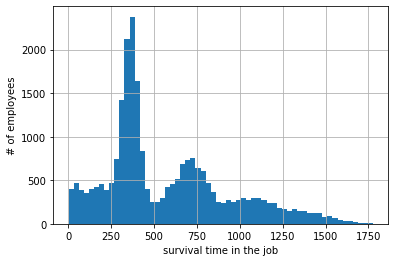

In [50]:
data['survival'].hist(bins=60)
plt.ylabel('# of employees')
plt.xlabel('survival time in the job')

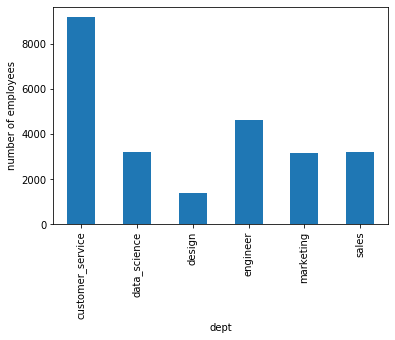

In [59]:
df = data.groupby('dept')['employee_id'].count()
plt.ylabel('number of employees')
df.plot.bar()

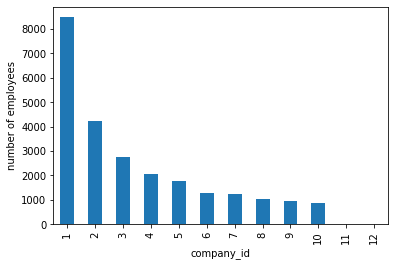

In [61]:
df = data.groupby('company_id')['employee_id'].count()
plt.ylabel('number of employees')
df.plot.bar()

### Table for daliy headcount

In [21]:
# Define useful information
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(data['company_id'].unique())

day = []
company = []
headcount = []

# Loop through date and company id
for date in unique_date:
    for idx in unique_company:
        total_join = len(data[(data['join_date'] <= str(date)) & (data['company_id'] == idx)])
        total_quit = len(data[(data['quit_date'] <= str(date)) & (data['company_id'] == idx)])
        day.append(date)
        company.append(idx)
        headcount.append(total_join - total_quit)

# Create table for day, employee_headcount, company_id
table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

In [23]:
table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


### Model build  
Since the question ask what is the most driven factor to leave a job, so the model accruracy is not the most important in here. 
But I would leave my model in here for reference. 

In [80]:
le = preprocessing.LabelEncoder()
X = data[['company_id','dept','seniority','salary']]
Y = data['quit']
X['dept'] = le.fit_transform(X['dept'])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [81]:
X.head()

,company_id,dept,seniority,salary
0,7,0,28,89000.0
1,7,4,20,183000.0
2,4,4,14,101000.0
3,7,0,20,115000.0
4,2,1,23,276000.0


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size = 0.2,random_state = 2000)

In [130]:
clf = RandomForestClassifier(max_depth=10, min_samples_leaf=10, random_state=25)
clf = clf.fit(X_train,y_train)
predict = clf.predict(X_test)
accuracy_score(y_test, predict)

0.5632463064157053

### Visionlize the importance of factors

In [132]:
# Feature importance
features = list(X_train.columns)
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.54721
seniority  | 0.23148
company_id | 0.15227
dept       | 0.06903


Outcome: Salaray really plays a large roll in here. This is make sense since people leave jobs is bcause they find a place they could earn more hoepfully in their life. And sometimes company cannot keep talent employee since it could not provide a competitive offer. 